# Projekt

## 1. Zielsetzung und Datenverständnis

In diesem Projekt wendet ihr selbst alle Konzepte aus den vorherigen Notebooks auf einen echten Datensatz an. Ziel ist es, mithilfe der bisher erlernten Methoden ein maschinelles Lernmodell zu entwickeln, das auf Basis physikalischer und materialtechnischer Eigenschaften vorhersagen kann, ob ein bestimmtes Ereignis eintritt. Darüber hinaus werden wir nicht nur vorhersagen können, **ob** ein Ereignis eintritt, sondern auch **wann** dies voraussichtlich geschieht.
Dabei werdet ihr vom Preprocessing, über Visualisierung und Feature-Engineering bis hin zur Evaluation eures fertigen Modells alles bisher Gelerntes anwenden und vertiefen.

### Anmerkungen zur Bewertung/Benotung

TODO

### Der Kontext

Steckverbindungen sind essenzielle Bauteile in vielen technischen Systemen – von der Automobilindustrie bis zur Elektronikfertigung. Mit der Zeit und unter Belastung (z. B. durch Vibration oder Temperaturwechsel) kann der elektrische Kontaktwiderstand steigen. Überschreitet er einen bestimmten Schwellenwert (meist 300 mΩ), gilt die Verbindung typischerweise als defekt.

Der vorliegende Datensatz enthält Informationen zu mehreren Steckverbindungen, die einem Experiment unterzogen wurden, in dem Steckvorgänge zyklisch simuliert wurden. Darunter findet ihr:

* **Materialeigenschaften** wie die Art der Beschichtung (Silber, Zinn) oder das Vorhandensein einer Zwischenschicht (Nickel),
* **Prozessparameter** wie Normalkraft, Frequenz und Bewegungshub,
* sowie die **Zyklenzahl**, bei der ein bestimmter Widerstandsschwellenwert (z. B. 1 mΩ, 20 mΩ, …, 300 mΩ) erstmals überschritten wurde – falls überhaupt.

Im Experiment wurden die Steckverbindungen unter bekannter Normalkraft, Frequenz und Hub zyklisch der Steckbelastung (Einstecken und Ausstecken) unterzogen. Die Zyklenanzahl war vorher fest definiert und richtete sich nach der durchschnittlich zu erwartenden Zahl an Steckvorgängen, die im Leben einer Steckverbindung zu erwarten ist. Eine Überschreitung des Schwellenwerts von 300 mΩ während des Experiments heißt also, dass diese Verbindung in der Realität ebenfalls wahrscheinlich defekt geworden wäre. Wir wollen diese Daten nun folgendermaßen nutzen:

### Das Ziel

Ihr werdet ein **zweistufiges Modell** entwickeln:

1. **Klassifikation**:
   Vorhersage, ob eine Steckverbindung **überhaupt** den Schwellenwert von 300 mΩ überschreiten wird, basierend auf rein physikalischen Features.
   → Features: Beschichtung, Zwischenschicht, Normalkraft, Frequenz und Hub
   → Zielgröße: *Ja (1)* oder *Nein (0)*

2. **Regression** (für die vorhergesagten "Ja"-Fälle):
   Schätzung, **nach wie vielen Belastungszyklen** der Widerstand von 300 mΩ erreicht wird, basierend auf der gemessenen Zyklenanzahl während des Experiments.
   → Features: Zyklus_bei_1mOhm, Zyklus_bei_2mOhm, Zyklus_bei_5mOhm, ..., Zyklus_bei_300mOhm
   → Zielgröße: *Zyklenanzahl*

Diese Kombination ermöglicht es, zunächst risikobehaftete Steckverbindungen zu identifizieren und anschließend genauer abzuschätzen, wann voraussichtlich ein kritischer Zustand eintritt, um gezielt Wartungsarbeiten einzuleiten.

### Der Datensatz

Die Datei `Schwellenwerte-Table 1.csv` enthält pro Zeile eine Steckverbindung mit:

* einem **Dateinamen** (`Datei`)
* Angaben zu **Material und Prozessparametern**
* Zyklenzahlen, bei denen bestimmte **Ohm-Schwellen überschritten wurden** (z. B. `Zyklus_bei_300_mOhm`)

  * Ein Wert von **-1** bedeutet: Schwelle wurde **nicht** überschritten.

## Aufgabe 1: Überblick verschaffen

Lade die Datei `Schwellenwerte-Table 1.csv` mit `pandas` ein und speichere die Daten in einem DataFrame namens `df`. Verschaffe dir einen Überblick:

* Gib die Form des DataFrames mit `.shape` aus
* Zeige die ersten 5 Zeilen mit `.head()`
* Liste die Spaltennamen auf
* Gib eine Übersicht der statistischen Kenngrößen aus (max, min, std, mean, ...)

In [1]:
### Importiere pandas
import pandas as pd

# Lade die CSV-Datei in einen DataFrame
df = pd.read_csv('../Data/Schwellenwerte-Table 1.csv')

# Zeige die Form des DataFrames, die ersten 5 Zeilen, die Spaltennamen und eine Übersicht der statistischen Kenngrößen an
print(df.shape)

# Zeige die ersten 5 Zeilen des DataFrames
print(df.head())

# Liste die Spaltennamen auf
print(df.columns)

# Gib eine Übersicht der statistischen Kenngrößen aus
print(df.describe())


(99, 14)
                                Datei Beschichtung_Ag_Sn Zwischenschicht_Ni  \
0    AgCu-200µm-1N-75000zyklen-V1.txt               Nein               Nein   
1   AgCu-200µm-2.5N-6100zyklen-V1.txt               Nein               Nein   
2  AgCu-200µm-2.5N-29000zyklen-V1.txt               Nein               Nein   
3     AgCu-200µm-5N-3000zyklen-V1.txt               Nein               Nein   
4    AgCu-200µm-5N-13000zyklen-V1.txt               Nein               Nein   

   Normalkraft  Frequenz  Bewegungshub  Zyklus_bei_1_mOhm  Zyklus_bei_2_mOhm  \
0          1.0         1           200                  0                 16   
1          2.5         1           200                  0                  0   
2          2.5         1           200                  0               6810   
3          5.0         1           200                  0                 -1   
4          5.0         1           200                  0                 -1   

   Zyklus_bei_5_mOhm  Zyklus_bei_10

## Aufgabe 2: Erste Visualisierungen – Muster in den Daten erkennen

Ein gutes Machine-Learning-Modell beginnt mit einem tiefen Verständnis für die Daten. In dieser Aufgabe wirst du verschiedene Visualisierungen erstellen, um ein Gefühl für die Verteilung, Streuung und Struktur der wichtigsten Merkmale im Datensatz zu bekommen.

### Hinweise

* Nutze `matplotlib` oder `seaborn`.
* Alle Plots sollten **sinnvoll beschriftet** sein (Achsen, Titel).
* Du musst an dieser Stelle **noch keine neuen Spalten erstellen**, sondern nur die bestehenden visualisieren.
* Versuche, alle Plots übersichtlich und interpretierbar zu gestalten.

### 2.1: Wie viele Steckverbindungen erreichen die einzelnen Schwellenwerte?

Untersuche für jede Widerstandsschwelle, **wie viele Steckverbindungen diesen Wert im Experiment erreicht haben**.

*Hinweis:* Die Spalten `Zyklus_bei_1_mOhm`, `Zyklus_bei_20_mOhm`, ..., `Zyklus_bei_300_mOhm` geben an, nach wie vielen Zyklen der jeweilige Schwellenwert überschritten wurde. Ein Wert von `-1` bedeutet: **nicht erreicht**.

**Plot:** Erstelle dann ein **Balkendiagramm**, das die Anzahl der Steckverbindungen zeigt, die den Schwellenwert erreicht haben.
* Zähle dafür für jede dieser Spalten, wie viele Steckverbindungen einen gültigen Zyklenwert (≠ –1) enthalten.
* Stelle diese Werte als Balkendiagramm dar.

> Ziel: Ein erster Eindruck zur Verteilung der erreichten Schwellwerte und über das Verhältnis von „defekt“ (300 mOhm erreicht) zu „nicht defekt“.


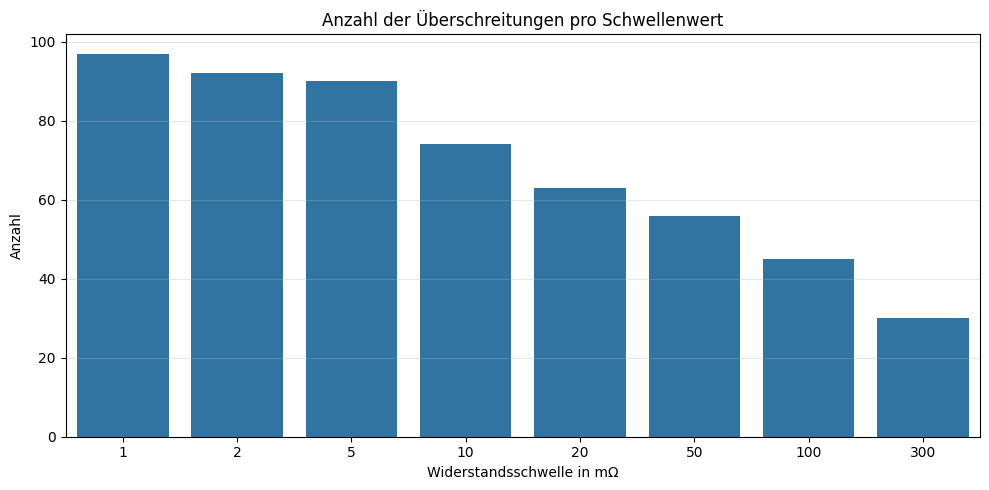

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Alle relevanten Spalten identifizieren
zyklus_cols = [col for col in df.columns if col.startswith("Zyklus_bei")]

# 2. Anzahl der gültigen Werte (≠ -1) pro Spalte zählen
überschreitungen = (df[zyklus_cols] != -1).sum()

# 3. Schwellenwerte extrahieren (z. B. aus 'Zyklus_bei_300_mOhm' → '300')
schwellenwerte = [int(col.replace("Zyklus_bei_", "").replace("_mOhm", "")) for col in überschreitungen.index]

# 5. Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=schwellenwerte, y=überschreitungen)
plt.title("Anzahl der Überschreitungen pro Schwellenwert")
plt.ylabel("Anzahl")
plt.xlabel("Widerstandsschwelle in mΩ")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### 2.2. Verteilung der numerischen physikalischen Merkmale untersuchen

   Analysiere die Verteilung der zentralen numerischen Eingangsgrößen:

   * `Normalkraft`
   * `Frequenz`
   * `Bewegungshub`

   **Plot:** Erstelle für jede dieser Spalten ein **Histogramm**.

   > Ziel: Gibt es auffällige Ausreißer? Gibt es dominante Wertebereiche? Welche Kombinationen der Features sind am wahrscheinlichsten?

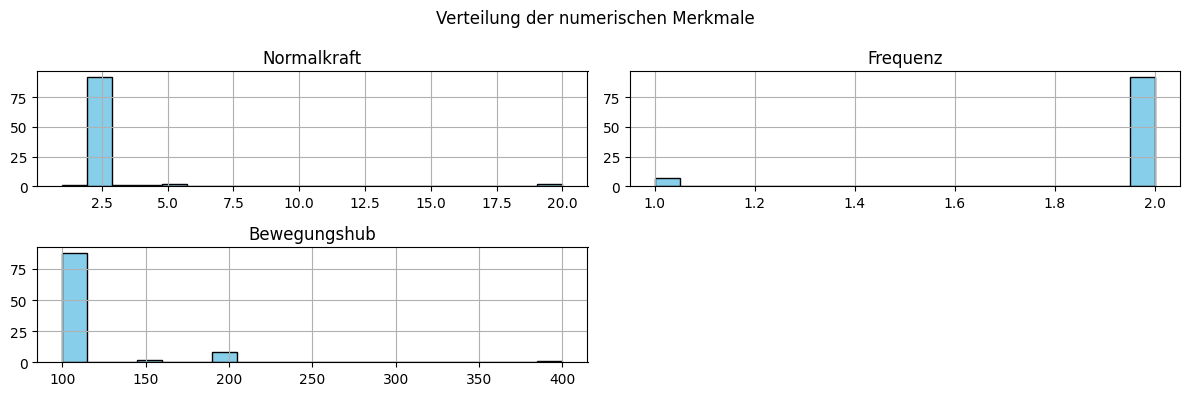

In [16]:
# Liste der numerischen physikalischen Merkmale
numerische_features = ["Normalkraft", "Frequenz", "Bewegungshub"]

# Plot
df[numerische_features].hist(bins=20, figsize=(12, 4), color="skyblue", edgecolor="black")
plt.suptitle("Verteilung der numerischen Merkmale")
plt.tight_layout()
plt.show()

### 2.3. Zyklenanzahlen beim Überschreiten der Schwellenwerte untersuchen

   Die Spalten `Zyklus_bei_1_mOhm`, `Zyklus_bei_20_mOhm`, ..., `Zyklus_bei_300_mOhm` enthalten die Zyklenzahlen, bei denen bestimmte Schwellenwerte überschritten wurden oder `-1`, wenn das nie passiert ist.

   **Schritte:**
   * Erstelle eine Kopie deines DataFrames namens `df_visual`.
   * Ersetze in der Kopie alle `-1`-Werte durch `np.nan`, damit matplotlib/seaborn sie als „fehlend“ behandelt.
   * Erstelle für die obigen Spalten einen **horizontalen Boxplot**, um zu analysieren:

     * Nach wie vielen Zyklen werden die Schwellen erreicht?

     * Wie groß ist die Streuung?

   > Ziel: Ein Gespür für die Streuung und die Zeitpunkte des Ausfalls über verschiedene Widerstandsschwellen hinweg bekommen.

In [4]:
import numpy as np

# Nur die Zyklus-Spalten extrahieren
df_visual = df[zyklus_cols].copy().replace(-1, np.nan)

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_visual, orient="h", palette="Set3")
plt.title("Boxplot der Zyklenzahlen beim Überschreiten der Schwellen")
plt.xlabel("Zyklenanzahl")
plt.ylabel("Widerstandsschwelle")
plt.grid(axis="x")
plt.show()


NameError: name 'zyklus_cols' is not defined

## Aufgabe 3: Preprocessing
In dieser Aufgabe soll der Datensatz sowohl für die Klassifikation als auch für die Regression vorbereitet werden. Ihr werdet entscheiden, wie mit fehlenden Werten umzugehen ist, Zielvariablen erstellen, standardisieren, one-hot-encoden und einen Train-Test-Split erstellen.


### 3.1. Fehlende Werte
* Identifiziert alle Spalten in eurem originalen DataFrame `df`, die fehlende Werte beinhalten. Was sollte mit diesen Datenpunkten geschehen? Entscheidet euch, ob ihr fehlende Werte ersetzt oder Zeilen mit fehlenden Werten ausschließt.

In [2]:
# Untersuche die fehlenden Werte
print(df.isna().sum())

# Droppe die Reihe mit dem fehlenden Wert in der Spalte 'Zyklus_5_mOhm'
df = df.dropna()

Datei                  0
Beschichtung_Ag_Sn     0
Zwischenschicht_Ni     0
Normalkraft            0
Frequenz               0
Bewegungshub           0
Zyklus_bei_1_mOhm      0
Zyklus_bei_2_mOhm      0
Zyklus_bei_5_mOhm      1
Zyklus_bei_10_mOhm     0
Zyklus_bei_20_mOhm     0
Zyklus_bei_50_mOhm     0
Zyklus_bei_100_mOhm    0
Zyklus_bei_300_mOhm    0
dtype: int64


### 3.2. Zielvariablen erstellen

* Für die **Klassifikation** benötigen wir eine Zielspalte, die angibt, _ob_ die 300 mOhm überschritten wurden oder nicht. Erstelle eine Spalte namens `target`, die wie folgt definiert ist:
    * **1**, wenn `Zyklus_300_mOhm` einen Wert größer als 0 enthält
    * **0**, wenn der Wert -1 ist
* Die Klassifikationszielvariable ist erstellt. Für die **Regression** ist die Zielvariable die _Zyklenanzahl_, bei der die 300 mOhm-Schwelle überschritten wird. Um später die Verarbeitung der Spalte `Zyklus_bei_300_mOhm` zu erleichtern, ersetzt alle Einträge `-1` durch `np.nan`.

In [5]:
# Ersetze alle Werte -1 durch np.nan 
df.replace(-1, np.nan, inplace=True)

# Erstelle die Zielvariable für die Klassifikation
df["target"] = (df["Zyklus_bei_300_mOhm"] > 0).astype(int)

### 3.3. Überflüssige Werte?
* Entscheidet euch, ob die Spalte `Datei` für das Training der zwei Modelle relevant ist, oder ob sie ignoriert und gedroppt werden sollte.
* Entscheidet euch, ob die Spalten `Zyklus_bei_1_mOhm` bis `Zyklus_bei_100_mOhm` für das Training der zwei Modelle relevant sind, oder ob sie ignoriert und gedroppt werden sollten.
* Begründet eure Entscheidungen und setzt sie ggf. um.

In [6]:
df.drop(columns=["Datei", "Zyklus_bei_1_mOhm", "Zyklus_bei_2_mOhm", "Zyklus_bei_5_mOhm", "Zyklus_bei_10_mOhm", "Zyklus_bei_20_mOhm", "Zyklus_bei_50_mOhm", "Zyklus_bei_100_mOhm"], inplace=True)

### 3.4. One-Hot-Encoding und Standardisierung
Bereite den Datensatz für das Training der Modelle vor:

1. Wandle **kategorische Variablen** in numerische mit One-Hot-Encoding um. Vermeide Multikollinearität.
2. Standardisiere alle **numerischen Features**, z. B. mit `StandardScaler` von scikit-learn
3. Speichere die verarbeiteten Features in einer neuen Variable `X_processed`

In [7]:
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=["target", "Zyklus_bei_300_mOhm"])  # Zielvariablen entfernen

# One-Hot-Encoding für kategorische Variablen
X_encoded = pd.get_dummies(X, columns=["Beschichtung_Ag_Sn", "Zwischenschicht_Ni"], drop_first=True)

# Standardisierung numerischer Spalten
numerical_cols = ["Normalkraft", "Frequenz", "Bewegungshub"]
scaler = StandardScaler()
X_encoded[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])

# Fertige Matrix
X_processed = X_encoded

### 3.5. Daten in Trainings- und Testmenge aufteilen

Teile die Features und Labels in Trainings- und Testdaten auf.

Anforderungen:
* 80 % Training, 20 % Test
* Speichere die Arrays als:
  - `X_train`, `X_test`
  - `y_train`, `y_test`
* Setze `random_state=42` für Reproduzierbarkeit

In [8]:
from sklearn.model_selection import train_test_split

target_cols = ["target", "Zyklus_bei_300_mOhm"]
y = df[target_cols]
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

In [9]:
from scripts.checker import check_preprocessing_pipeline
check_preprocessing_pipeline(
    df_processed=df,
    X_processed=X_processed,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test
)

✅ Alle echten NaNs entfernt und -1 korrekt durch NaN ersetzt. 
 -------------------- 
 Info: 

<class 'pandas.core.frame.DataFrame'>
Index: 98 entries, 0 to 98
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Beschichtung_Ag_Sn   98 non-null     object 
 1   Zwischenschicht_Ni   98 non-null     object 
 2   Normalkraft          98 non-null     float64
 3   Frequenz             98 non-null     int64  
 4   Bewegungshub         98 non-null     int64  
 5   Zyklus_bei_300_mOhm  30 non-null     float64
 6   target               98 non-null     int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 6.1+ KB
None

 ✅ Zielvariable korrekt erstellt.
✅ One-Hot-Encoding korrekt angewendet.

 Berechnete Mittelwerte und Standardabweichungen: 

Mittelwerte: 
 Normalkraft     6.060911e-17
Frequenz       -1.212182e-16
Bewegungshub   -1.246169e-17
dtype: float64
Standardabweichungen: 
 Normalkraft     1.0
Fre

## Aufgabe 4: Logistisches Regressionsmodell trainieren

Trainiere ein logistisches Regressionsmodell auf den Trainingsdaten.

Anforderungen:
* Verwende `LogisticRegression` aus `sklearn.linear_model`
* Speichere das Modell in einer Variable `model`
* Trainiere mit `.fit(X_train, y_train)`

In [13]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
from scripts.checker import check_model_training
# check_model_training(<>Hier euer model, X_train, y_train einfügen<>)

## Aufgabe 5: Scatterplot der Vorhersagen

Visualisiere die Modellvorhersagen mithilfe eines Scatterplots:

Schritte:
1. Wähle zwei numerische Features, z. B. `Kontaktkraft_N` und `Steckzyklen`
2. Plotte die Testdaten in diesen zwei Dimensionen
3. Farbe: Nutze `model.predict(X_test)` als Farbe (0 oder 1)


In [ ]:
### Hier ist Platz für eure Lösung

## Aufgabe 6: Modell evaluieren

Bewerte die Qualität deiner Vorhersagen auf dem Testdatensatz.

Berechne folgende Metriken mit scikit-learn:

- Accuracy
- Precision
- Recall
- F1-Score
- Confusion Matrix
- ROC-AUC

> Hinweis: Verwende `model.predict(X_test)` für die Klassenvorhersage und `model.predict_proba(X_test)[:, 1]` für Wahrscheinlichkeiten.

Speichere die Vorhersagen in `y_pred` und die Wahrscheinlichkeiten in `y_prob`.

In [ ]:
### Hier ist Platz für eure Lösung

In [ ]:
### Überprüft eure Lösung
from scripts.checker import check_metrics
# check_metrics(<>Hier eure y_test, y_pred, y_prob einfügen<>)

## Aufgabe 7: Interpretation der Feature-Gewichte

Nutze die Koeffizienten des Modells, um zu verstehen, welche Features das Modell beeinflussen.

Schritte:
1. Erstelle ein DataFrame, das die Features (`X_prepared.columns`) den zugehörigen Koeffizienten (`model.coef_`) gegenüberstellt.
2. Sortiere es nach der Stärke des Einflusses (positiv oder negativ).
3. Stelle die Top-10 wichtigsten Features in einem Balkendiagramm dar.


In [ ]:
### Hier ist Platz für eure Lösung

In [ ]:
### Überprüft eure Lösung
from scripts.checker import check_coefficients
# check_coefficients(<>Hier euer model, X_prepared einfügen<>)

In [ ]:
# Spalten, die ausgeschlossen werden sollen
exclude_cols = ["Datei", "Beschichtung_Ag_Sn", "Zwischenschicht_Ni", "Normalkraft", "Frequenz", "Bewegungshub", "target"]

# Nur numerische Spalten, die nicht ausgeschlossen sind
corr_cols = [col for col in df.select_dtypes(include=["number"]).columns if col not in exclude_cols]

sns.heatmap(df[corr_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Korrelationsmatrix numerischer Merkmale")

sns.scatterplot(x="Zyklus_bei_100_mOhm", y="Zyklus_bei_300_mOhm", data=df, hue="target", style="target", palette="Set1")
plt.title("Zusammenhang zwischen 100 mΩ und 300 mΩ")